# 고용, 소득으로 알아본 저소득층 복지

- 2022년 기준 국가별 행복 순위 1위부터 핀란드, 덴마크, 아이슬란드, 유럽 등 최상위 국가군 차치, 프랑스(20위), 한국(54위)  
- 저소득층으로 이동한 가구는 빈곤층에서 벗어나지 못할 확률이 높고 중산층 붕괴되는 경향  
- **사회적 불평등, 계층 이동 관점으로 시각 확대**

### 참조

- [나무위키 검색ㅡ저소득층](https://namu.wiki/w/저소득층)
- [e-나라지표](https://www.index.go.kr/unify/idx-info.do?idxCd=8065)

In [103]:
"""고용, 소득으로 알아본 국가별 저소득층 복지 분석을 위한 모듈"""


def scrap(url: str, xpath=None, tag=None, cls_name=None):
	"""webscraping by a given xpath or a html tag with class name"""
	try:
		from selenium import webdriver
		from bs4 import BeautifulSoup
	except ModuleNotFoundError as e:
		print(e)
	try:
		driver = webdriver.Chrome()
	except FileNotFoundError as e:
		print('cannot excute chrome broswer')
		print(e)
	driver.get(url)
	
	article_title = []
	video_title = []
	video_view = []

	# get youtube video title
	if xpath is not None:
		driver.find_elements_by_xpath(xpath)
		html = driver.page_source
		bs = BeautifulSoup(html, 'html.parser')
		contents = bs.select('a#video-title')
		for video in contents: 
			video_title.append(video['title'])
		driver.close()
		return video_title
	
	elif tag is not None:
		# get naver article headers
		html = driver.page_source
		bs = BeautifulSoup(html, 'html.parser')
		contents = bs.findAll(tag, {'class': cls_name})
		for a in contents:
			article_title.append(a.text)

		# get youtube video click view
		# (조회수 33만회, 2개월) -> 33 
		for info in contents:
			info = info.text
			if info.startswith('조회수'):
				info = info.split()[1]
				info = info.replace('만회', '')
				video_view.append(int(info))
		driver.close()
		return article_title, video_view


def mkWordCloud(context=None, except_kwrd=None, filename='wcimg'):
	"""make WordCloud image
	context : text string list
	except_kwrd : keyword list has to be excepted from context
	filename : png file name
	"""
	try:
		import matplotlib.pyplot as plt
		import platform
		from konlpy.tag import Okt
		from collections import Counter
		from wordcloud import WordCloud
	except ModuleNotFoundError as e:
		print(e)

	# hangeul font path
	if platform.system() == 'Windows':
		path = r'c:\Windows\Fonts\malgun.ttf'
	elif platform.system() == 'Darwin':  # Mac
		path = r'/System/Library/Fonts/AppleGothic'
	else:  # Linux
		path = r'/usr/share/fonts/truetype/name/NanumMyeongjo.ttf'

	# extract keyword list except the search keyword
	okt = Okt()
	wordlist = []
	for text in context:
		for key in except_kwrd:
			if key in text:
				text = text.replace(key, '')
				for word, tag in okt.pos(text):
					if tag in ['Noun', 'Adjective', 'Verb']:
						if key not in word:
							wordlist.append(word)
	frequency = Counter(wordlist).most_common(30)

	# save and display wordcloud image
	wc = WordCloud(font_path=path)
	wc = wc.generate_from_frequencies(dict(frequency))
	wc.to_file(f'{filename}.png')

	plt.figure(figsize=(10, 6))
	plt.axis('off')
	plt.imshow(wc)
	plt.show()


def sendQuery(csv_file, hostname, username, passwd, dbname, table_name):
	"""send insert queries to database by csv file"""
	# open and read csv data
	try:
		import pymysql
		import csv
		from pymysql import OperationalError
	except ModuleNotFoundError as e:
		print(e)
	file = open(csv_file, mode='r', encoding='utf-8')
	data = csv.reader(file)
	header = next(data)

	# connect to MySQL DB
	conn = pymysql.connect(host=hostname, user=username,
						   password=passwd, database=dbname, charset='utf8')
	db = conn.cursor(pymysql.cursors.DictCursor)
	db.execute('USE '+dbname)
	
	# send insert queries
	if db.rowcount == 0:
		for row in data:
			row = str(row).lstrip('[')
			row = row.rstrip(']')
			db.execute('set foreign_key_checks=0')
			try:
				db.execute(f'INSERT INTO {table_name}({", ".join(header)}) VALUES ({row})')
			except OperationalError as e:
				print(e)
				file.close()
				db.close()
				conn.close()
			db.execute('set foreign_key_checks=1')
			db.connection.commit()
	file.close()
	db.close()
	conn.close()


def getData(hostname, username, passwd, dbname, table_name):
	"""return pandas DataFrame from database"""
	try:
		import pandas as pd
		import pymysql
	except ModuleNotFoundError as e:
		print(e)

	conn = pymysql.connect(host=hostname, user=username,
						   password=passwd, database=dbname, charset='utf8')
	db = conn.cursor(pymysql.cursors.DictCursor)
	db.execute('USE '+dbname)
	db.execute(f'SELECT * FROM {table_name}')
	data = db.fetchall()
	data = pd.DataFrame(data)
	db.close()
	conn.close()
	return data


def plotgraph(data, title, xlabel, ylabel, save_name):
	try:
		import numpy as np
		import platform
		import matplotlib.pyplot as plt
		from matplotlib import font_manager as fm, rc
	except ModuleNotFoundError as e:
		print(e)

	if platform.system() == 'Windows':
		font_fname = r'c:\Windows\Fonts\malgun.ttf'
	elif platform.system() == 'Darwin':
		font_fname = r'/System/Library/Fonts/AppleGothic'
	else:
		font_fname = r'/usr/share/fonts/truetype/name/NanumMyeongjo.ttf'

	font_family = fm.FontProperties(fname=font_fname).get_name()
	plt.rcParams['font.family']=font_family

	plt.figure(figsize=(10, 6), layout='constrained')
	for i in range(len(data)):
		plt.plot(data.iloc[i])
	plt.title(title, fontsize=20, pad=10)
	plt.margins(0.1)
	plt.xticks(rotation=45)
	plt.xlabel(xlabel, fontsize=15)
	plt.ylabel(ylabel, fontsize=15)
	plt.legend(data.index, loc=2);
	# plt.savefig(f'{save_name}', dpi=200);

In [112]:
import welfare
from IPython import display

---
## <span style='color:#7eb54e'>**welfare**</span> 데이터베이스 설계

- 국가 <span style='color:blue'>**country**</span>를 세가지 데이터의 <span style='color:blue'>**주요 공통키**</span>로 설정
- <span style='color:#7eb54e'>**국가별 저소득층 소득**</span> 데이터(2017~2021) : <span style='color:blue'>**global_income**</span>
- <span style='color:#7eb54e'>**국가별 실업률**</span> 데이터(2017~2021) : <span style='color:blue'>**unemployment_rate**</span>
- <span style='color:#7eb54e'>**국가별 사회적 지출비용**</span> 데이터(2019) : <span style='color:blue'>**social_spending**</span>

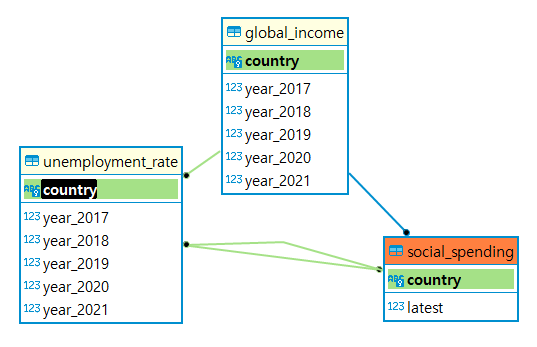

In [117]:
display.Image('Data/img/welfareDB설계.png')

In [111]:
# 네이버 검색키워드1 "소득지원정책" 관련 게시글 제목 추출 
url = 'https://search.naver.com/search.naver?where=nexearch&sm=top_hty&fbm=0&ie=utf8&query=%EC%86%8C%EB%93%9D%EC%A7%80%EC%9B%90%EC%A0%95%EC%B1%85'
title = welfare.scrap(url, tag='a', cls_name=['total_tit', 'link_tit'])
title = title[0]

# 네이버 검색키워드2 "저소득 지원" 관련 게시글 제목 추출 
url = 'https://search.naver.com/search.naver?where=nexearch&sm=tab_jum&query=%EC%A0%80%EC%86%8C%EB%93%9D+%EC%A7%80%EC%9B%90'
title2 = welfare.scrap(url, tag='a', cls_name=['total_tit', 'news_tit'])
title2 = title2[0]
title.extend(title2)

# 네이버 "저소득" 및 "소득지원정책" 키워드 wordcloud 이미지 저장 및 출력
exkwrd = ['저소득', '저소득층', '소득', '지원', '정책', '소득지원정책']
welfare.mkWordCloud(title, exkwrd, '소득지원정책')

# youtube 검색키워드 "저소득층 지원" wordcloud 이미지 저장 및 출력
url = 'https://www.youtube.com/results?search_query=%EC%A0%80%EC%86%8C%EB%93%9D%EC%B8%B5+%EC%A7%80%EC%9B%90&sp=CAMSBAgFEAE%253D'
youtube_title = welfare.scrap(url, xpath='//*[@id="meta"]')

exkwrd = ['소득층', '저소득층', '지원', '저소득층지원']
welfare.mkWordCloud(title, exkwrd, '저소득층지원')

# 데이터베이스에 데이터 저장
welfare.sendQuery('Data/global_income.csv', 'localhost', 'user0728', 'test1234', 'welfare', 'global_income')
welfare.sendQuery('Data/social_spending.csv', 'localhost', 'user0728', 'test1234', 'welfare', 'social_spending')
welfare.sendQuery('Data/unemployment_rate.csv', 'localhost', 'user0728', 'test1234', 'welfare', 'unemployment_rate')

---
## #청년, #월세, #생활, #목돈, #공제<span style='font-size: 50%'> 저소득층지원 관련 키워드</span>

- 소득과 관련된 내용이 당연히 가장 중점
- 생활과 직결된 요소들

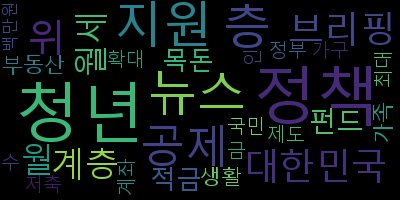

In [115]:
display.Image('Data/img/소득지원정책.png')

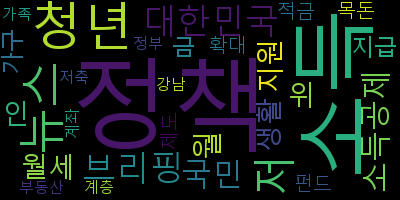

In [116]:
display.Image('Data/img/저소득층지원.png')

---

## 저소득층 소득 변화<span style='font-size: 60%'> Decile ratios of gross earnings</span>

- 출처 : [OECD iLibrary Decile ratios of gross earnings 2021](https://doi.org/10.1787/data-00302-en)
- 카테고리 : Home  Statistics  OECD Employment and Labour
- 상근 부양 직원의 총 소득에 대한 소득 상위 십분위수 한도, 중위 소득의 2/3 미만을 버는 근로자의 총 부양 고용에서 차지하는 비중

                year_2017  year_2018  year_2019  year_2020  year_2021
country                                                              
Australia           15.06      15.43      15.46       0.00       0.00
Canada              22.01      20.68      19.38      18.67      19.54
Denmark              8.52       8.73       0.00       0.00       0.00
France               0.00       7.74       0.00       0.00       0.00
Germany             18.21      17.83      17.64      16.98       0.00
Italy                0.00       3.71       4.89       0.00       0.00
Japan               12.32      12.12      11.79      10.88      10.66
Korea               22.30      19.04      16.96      15.96      15.63
Norway               0.00       0.00       0.00       0.00       0.00
Sweden               0.00       0.00       0.00       0.00       0.00
Switzerland          0.00      12.12       0.00      12.00       0.00
United Kingdom      18.98      18.96      18.06      18.02      16.66
United States       

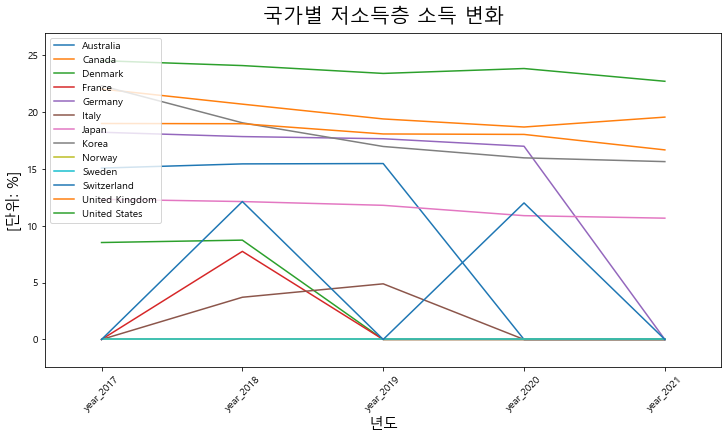

In [89]:
gbincome = welfare.getData('localhost', 'user0728', 'test1234', 'welfare', 'global_income')
gbincome.set_index('country', inplace=True)
gbincome = gbincome.astype('float')
print(gbincome)
welfare.plotgraph(gbincome, '국가별 저소득층 소득 변화', '년도', '[단위: %]', '/Data/img/저소득층소득변화.png')

---

## 실업률<span style='font-size: 60%'> Unemployment Rate</span>

- 출처 : [OECD Data](https://data.oecd.org)
- Employment 관련 데이터들은 1주일 30시간 미만 등 단시간 근로자 포함해서 단순 고용 여부를 지표화한 것들이 있어서 실업율 변화 데이터를 사용

                year_2017  year_2018  year_2019  year_2020  year_2021
country                                                              
Australia           5.594      5.300      5.159      6.462      5.116
Canada              6.400      5.892      5.733      9.558      7.467
France              9.425      9.025      8.433      8.033      7.883
Germany             3.567      3.208      2.975      3.625      3.575
Italy              11.258     10.600      9.933      9.300      9.558
Japan               2.808      2.442      2.350      2.775      2.817
Korea               3.683      3.833      3.783      3.942      3.675
OECD Total          5.940      5.494      5.421      7.162      6.161
United Kingdom      4.425      4.100      3.825      4.575      4.525
United States       4.350      3.900      3.667      8.092      5.367


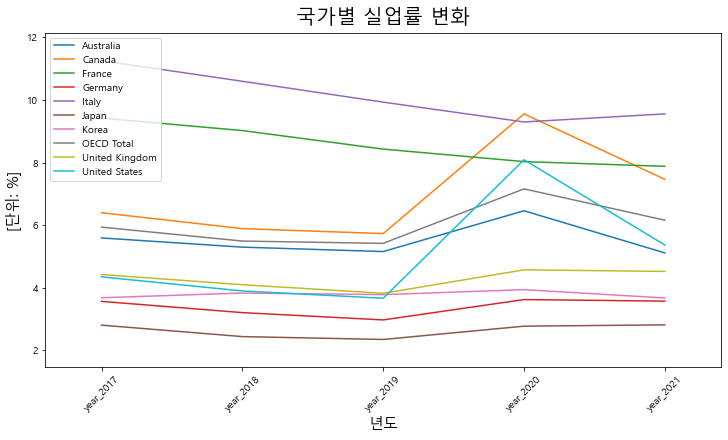

In [109]:
unemployment_rate = welfare.getData('localhost', 'user0728', 'test1234', 'welfare', 'unemployment_rate')
unemployment_rate.set_index('country', inplace=True)
unemployment_rate = unemployment_rate.astype('float')
print(unemployment_rate)
welfare.plotgraph(unemployment_rate, '국가별 실업률 변화', '년도', '[단위: %]', '/Data/img/국가별실업률변화.png')

---

## 사회적 지출<span style='font-size: 60%'> Social Pending</span>

- 출처 : [OECD Data](https://data.oecd.org/socialexp/social-spending.htm)
- 사회적 지출은 현금 혜택, 재화와 서비스의 직접적인 현물 제공, 사회적 목적을 위한 세제 혜택으로 구성
- 혜택은 저소득 가구, 노인, 장애인, 병자, 실업자 또는 청년을 대상
- 1인당 GDP 또는 USD의 백분율로 측정

                latest
country               
Australia       16.710
Canada          17.985
France          30.987
Germany         25.881
Italy           28.195
Japan           22.324
Korea           12.200
OECD Total      20.031
United Kingdom  20.616
United States   18.710


<Figure size 720x432 with 0 Axes>

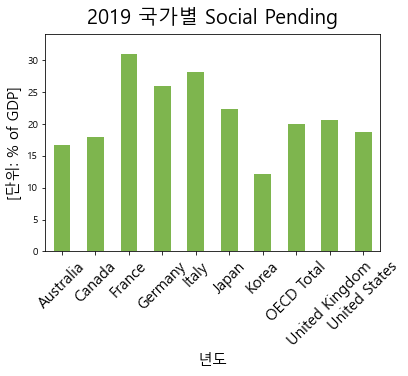

In [87]:
import numpy as np
import platform
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rc

if platform.system() == 'Windows':
	font_fname = r'c:\Windows\Fonts\malgun.ttf'
elif platform.system() == 'Darwin':
	font_fname = r'/System/Library/Fonts/AppleGothic'
else:
	font_fname = r'/usr/share/fonts/truetype/name/NanumMyeongjo.ttf'

font_family = fm.FontProperties(fname=font_fname).get_name()
plt.rcParams['font.family']=font_family

social_spending = welfare.getData('localhost', 'user0728', 'test1234', 'welfare', 'social_spending')
social_spending.set_index('country', inplace=True)
social_spending = social_spending.astype('float')
print(social_spending)

plt.figure(figsize=(10, 6), layout='constrained')
c = ['#7eb54e', '#7eb54e', 'orange', 'orange', 'orange', 'orange',
		 '#7eb54e', '#7eb54e', '#7eb54e', '#7eb54e' ]
social_spending.plot.bar(color=c, legend=False)
plt.title('2019 국가별 Social Pending', fontsize=20, pad=10)
plt.margins(0.1)
plt.xticks(rotation=45, fontsize=15)
plt.xlabel('년도', fontsize=15)
plt.ylabel('[단위: % of GDP]', fontsize=15)
plt.show()
# plt.savefig('/Data/img/사회적지출비용 변화.png', dpi=200)

---
## 고용, 소득지원 현황

- field
- field

---
## 선별적 복지 VS 보편적 복지 떠나 제로섬게임 형태에서 벗어날 수 있을까?

- 미국을 제외한 유럽은 보편적 복지 추구, 한국은 선별적 복지 방향
- 고용률은 경기 순환에 민감하지만 장기적으로는 정부의 **고등 교육** 및 **소득 지원 정책**과 **여성 및 취약 계층의 고용을 촉진**하는 정책의 영향이 큼